## Import libaries

In [ ]:
!pip uninstall dea_ml -y

In [ ]:
!pip install -e dea_ml

In [1]:
import os
import json
import xarray as xr
import geopandas as gpd
from odc.stats.tasks import TaskReader
from odc.stats.model import OutputProduct

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Enter the (old) X and Y Tile ID of the tile you want to run

In [5]:
tile_x = '+0031'  #+0031,+0003 +0030,-0002  -0001,+0010
tile_y = '+0038' 

### Open tiles geojson and find the new tile-id for the location entered 

In [6]:
tiles=gpd.read_file('https://github.com/digitalearthafrica/crop-mask/blob/main/testing/eastern_cropmask/data/gm_s2_2019-2019--P1Y.geojson?raw=true')
t=[]
for index, row in tiles.iterrows():
    x,y = tiles.loc[index]['title'].split(",")
    if (x==tile_x) & (y==tile_y): 
        x,y = int(x)+181, int(y)+77
        new_title = str(x)+","+str(y)
        t.append(x)
        t.append(y)
        print(new_title)

212,115


### Extract the tasks object for that tile

In [7]:
name, version = 'gm_s2_semiannual', '0-1-0'
op = OutputProduct(
            name='gm_s2_semiannual',
            version='0-1-0',
            short_name='gm_s2_semiannual',
            location=f"s3://dummy-bucket/{name}/{version}",
            properties={"odc:file_format": "GeoTIFF"},
            measurements=['red'],
        )

taskdb = TaskReader('s3://deafrica-services/crop_mask_eastern/1-0-0/gm_s2_semiannual_all.db', product=op)
task = taskdb.load_task(('2019--P1Y', t[0], t[1]))

### Optionally export tile geojson to view

In [8]:
with open('task_tile_check.geojson', 'w') as fh:
    json.dump(task.geobox.extent.to_crs('epsg:4326').json, fh, indent=2)

### Find the index of the tile we want to run

In [9]:
tile_index_to_run = []
all_tiles = list(taskdb.all_tiles)
for i, index in zip(all_tiles, range(0, len(all_tiles))):
    if (i[1]==t[0]) & (i[2]==t[1]):
        tile_index_to_run.append(index)
        print(index)

3135


### Run the crop-mask algo using odc-stats

In [ ]:
# os.system("cm-pred run "\
#           "s3://deafrica-data-dev-af/crop_mask_eastern/0-1-0/gm_s2_semiannual_all.db "\
#           "--config=https://raw.githubusercontent.com/digitalearthafrica/crop-mask/main/production/dea_ml/dea_ml/config/plugin_product.yaml "\
#           "--plugin-config=https://raw.githubusercontent.com/digitalearthafrica/crop-mask/main/production/dea_ml/dea_ml/config/ml_config.yaml "\
#           "--resolution=40 "\
#           "--threads=10 "\
#           "--memory-limit=90Gi "\
#           "--location=file:///home/jovyan/git/crop-mask/production/{product}/{version} "+str(tile_index_to_run[0])
#          )

### Or can run with cmd line, will see print statements

In [10]:
%%time
!cm-pred run s3://deafrica-services/crop_mask_eastern/1-0-0/gm_s2_semiannual_all.db --config=file:///home/jovyan/git/crop-mask/production/dea_ml/dea_ml/config/plugin_product_northern.yaml  --plugin-config=file:///home/jovyan/git/crop-mask/production/dea_ml/dea_ml/config/ml_config_northern_notebook.yaml  --resolution=20 --threads=6 --memory-limit=50Gi --location=file:///home/jovyan/git/crop-mask/production/{product}/{version} 3135

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
[2021-09-17 05:58:03,096] {pred_run.py:150} INFO - Config overrides: {'filedb': 's3://deafrica-services/crop_mask_eastern/1-0-0/gm_s2_semiannual_all.db', 'threads': 6, 'memory_limit': '50Gi', 'output_location': 'file:///home/jovyan/git/crop-mask/production/{product}/{version}', 'heartbeat_filepath': '/tmp/cm-heartbeat.txt'}
[2021-09-17 05:58:03,096] {pred_run.py:167} INFO - Using this config: TaskRunnerConfig(filedb='s3://deafrica-services/crop_mask_eastern/1-0-0/gm_s2_semiannual_all.db', aws_unsigned=True, plugin='pred-gm-s2', plugin_config={'urls': {'slope': 'https://deafrica-input-datasets.s3.af-south-1.amazonaws.com/srtm_dem/srtm_africa_slope.tif', 'model': '///home/jovyan/git/crop-mask/testing/northern_cropmask/results/northern

## Plot the results

In [11]:
a= 'x'+str(t[0])
b='y'+str(t[1])
prob=xr.open_rasterio('crop_mask_northern/1-0-0/'+a+'/'+b+'/2019--P1Y/crop_mask_northern_'+a+b+'_2019--P1Y_prob.tif')
print(prob)
prob.squeeze().plot.imshow(size=6);

<xarray.DataArray (band: 1, y: 4800, x: 4800)>
[23040000 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 3.744e+06 3.744e+06 3.744e+06 ... 3.648e+06 3.648e+06
  * x        (x) float64 2.976e+06 2.976e+06 2.976e+06 ... 3.072e+06 3.072e+06
Attributes:
    transform:      (20.0, 0.0, 2976000.0, 0.0, -20.0, 3744000.0)
    crs:            +init=epsg:6933
    res:            (20.0, 20.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


<xarray.DataArray (band: 1, y: 4800, x: 4800)>
[23040000 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 3.744e+06 3.744e+06 3.744e+06 ... 3.648e+06 3.648e+06
  * x        (x) float64 2.976e+06 2.976e+06 2.976e+06 ... 3.072e+06 3.072e+06
Attributes:
    transform:      (20.0, 0.0, 2976000.0, 0.0, -20.0, 3744000.0)
    crs:            +init=epsg:6933
    res:            (20.0, 20.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


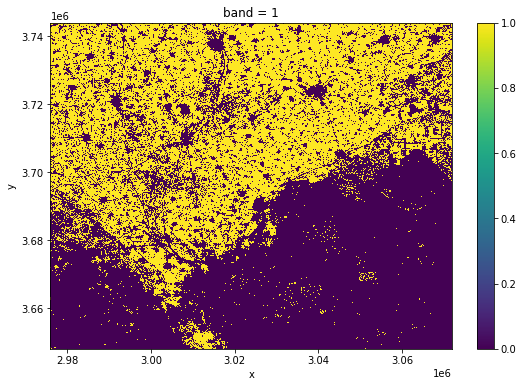

In [12]:
mask=xr.open_rasterio('crop_mask_northern/1-0-0/'+a+'/'+b+'/2019--P1Y/crop_mask_northern_'+a+b+'_2019--P1Y_mask.tif')#.squeeze().plot.imshow(size=6);
print(mask)
mask.squeeze().plot.imshow(size=6);

<xarray.DataArray (y: 4800, x: 4800)>
[23040000 values with dtype=uint8]
Coordinates:
    band     int64 1
  * y        (y) float64 3.744e+06 3.744e+06 3.744e+06 ... 3.648e+06 3.648e+06
  * x        (x) float64 2.976e+06 2.976e+06 2.976e+06 ... 3.072e+06 3.072e+06
Attributes:
    transform:      (20.0, 0.0, 2976000.0, 0.0, -20.0, 3744000.0)
    crs:            +init=epsg:6933
    res:            (20.0, 20.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


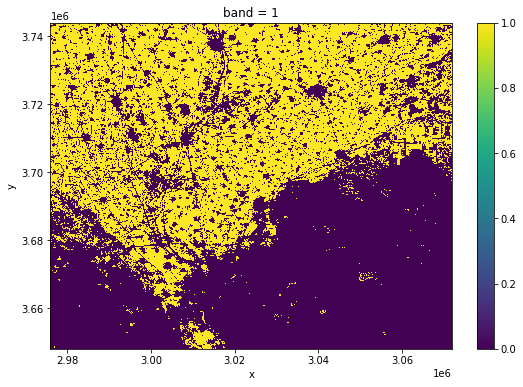

In [13]:
mode=xr.open_rasterio('crop_mask_northern/1-0-0/'+a+'/'+b+'/2019--P1Y/crop_mask_northern_'+a+b+'_2019--P1Y_filtered.tif').squeeze()#.plot.imshow(size=6);
print(mode)
mode.squeeze().plot.imshow(size=6);

### Remove all files

In [ ]:
!rm -r -f crop_mask_northern

Sync files from AWS

In [ ]:
!aws s3 sync s3://deafrica-data-dev-af/crop_mask_western/ crop_mask_western --no-sign-request
